This notebook will hopefully contain timeseries that plot continuous data from moorings alongside model output For all depths. For now, it is focussing on just plotting model output for all depths. 

In [1]:
import sys
sys.path.append('/ocean/kflanaga/MEOPAR/analysis-keegan/notebooks/Tools')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import netCDF4 as nc
import xarray as xr
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools, places
import gsw 
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import math
import pickle
import cmocean
import json
import Keegan_eval_tools as ket
from collections import OrderedDict
from matplotlib.colors import LogNorm

fs=16
mpl.rc('xtick', labelsize=fs)
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

import warnings
#warnings.filterwarnings('ignore')
from IPython.display import Markdown, display

%matplotlib inline

In [3]:
saveloc='/ocean/kflanaga/MEOPAR/ptrc_extractions/temp'
dataloc='/ocean/kflanaga/MEOPAR/mooredData'
PATH='/results2/SalishSea/nowcast-green.201905/'
year=2019
Mooring='PointWilliams'

In [4]:
##### Loading in pickle file data
with open(os.path.join(dataloc,f'daily_data_{Mooring}_{year}.pkl'),'rb') as hh:
    data=pickle.load(hh)

In [5]:
def get_ij(lat,lon):
    method = 'nearest'
    jj = jjii.jj.sel(lats=lat, lons=lon, method=method).item()
    ii = jjii.ii.sel(lats=lat, lons=lon, method=method).item()
    return ii, jj

In [6]:
# get model i,j of location S3 from places
ij,ii=places.PLACES['PointWilliams']['NEMO grid ji']
ik=0 # choose surface level


In [7]:
ii

231

In [8]:
bio=xr.open_mfdataset(saveloc+'/'+'ptrc20150101_20150101PointWilliams.nc')

In [9]:
x=bio.nav_lat.isel()

Ok, so I do not actually need to enter in the Y and X values because the data already knows the Y and X values. I just need to enter 0 to say 'yes I want that one that we have'

In [25]:
bio

<xarray.Dataset>
Dimensions:               (axis_nbounds: 2, deptht: 40, nvertex: 4, time_counter: 24, x: 1, y: 1)
Coordinates:
  * deptht                (deptht) float32 0.5 1.5 2.5 3.5 ... 387.6 414.5 441.5
    nav_lat               (y, x) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    nav_lon               (y, x) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    time_centered         (time_counter) datetime64[ns] dask.array<chunksize=(24,), meta=np.ndarray>
  * time_counter          (time_counter) datetime64[ns] 2015-01-01T00:30:00 ....
Dimensions without coordinates: axis_nbounds, nvertex, x, y
Data variables:
    bounds_lat            (y, x, nvertex) float32 dask.array<chunksize=(1, 1, 4), meta=np.ndarray>
    bounds_lon            (y, x, nvertex) float32 dask.array<chunksize=(1, 1, 4), meta=np.ndarray>
    ciliates              (time_counter, deptht, y, x) float32 dask.array<chunksize=(24, 40, 1, 1), meta=np.ndarray>
    deptht_bounds         (deptht, axis_nbounds) float32 dask.array<chunksize=(40, 2), meta=np.ndarray>
    diatoms               (time_counter, deptht, y, x) float32 dask.array<chunksize=(24, 40, 1, 1), meta=np.ndarray>
    flagellates           (time_counter, deptht, y, x) float32 dask.array<chunksize=(24, 40, 1, 1), meta=np.ndarray>
    nitrate               (time_counter, deptht, y, x) float32 dask.array<chunksize=(24, 40, 1, 1), meta=np.ndarray>
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(24, 2), meta=np.ndarray>
    time_counter_bounds   (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(24, 2), meta=np.ndarray>
Attributes:
    name:         SalishSea_1h_20150101_20150105
    description:  biogeochemical variables
    title:        biogeochemical variables
    Conventions:  CF-1.6
    timeStamp:    2019-Sep-23 16:40:15 GMT
    uuid:         a311c5f6-4083-4743-8125-5b0f43937446
    history:      Tue Mar 16 14:32:16 2021: ncks -v diatoms,ciliates,flagella...
    NCO:          "4.5.4"

In [10]:
%%time
tt=bio.time_counter
mod_depth=bio.deptht
mod_nitrate=(bio.nitrate.isel(y=0,x=0))
#diatom=bio.diatoms.isel(deptht=ik,y=0,x=0)
#flagellate=bio.flagellates.isel(deptht=ik,y=0,x=0)
#ciliate=bio.ciliates.isel(deptht=ik,y=0,x=0)
#mod_Chl=(diatom+flagellate+ciliate)*1.8

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.38 ms


Wait, can I do this with three 1d arrays rather than 1 2d array? 

In [35]:
nitrate=pd.DataFrame(np.transpose(np.array(mod_nitrate)),columns=np.array(tt),index=np.array(mod_depth))
nitrate=nitrate.loc[~(nitrate==0).all(axis=1)]

In [37]:
nitrate.columns

DatetimeIndex(['2015-01-01 00:30:00', '2015-01-01 01:30:00',
               '2015-01-01 02:30:00', '2015-01-01 03:30:00',
               '2015-01-01 04:30:00', '2015-01-01 05:30:00',
               '2015-01-01 06:30:00', '2015-01-01 07:30:00',
               '2015-01-01 08:30:00', '2015-01-01 09:30:00',
               '2015-01-01 10:30:00', '2015-01-01 11:30:00',
               '2015-01-01 12:30:00', '2015-01-01 13:30:00',
               '2015-01-01 14:30:00', '2015-01-01 15:30:00',
               '2015-01-01 16:30:00', '2015-01-01 17:30:00',
               '2015-01-01 18:30:00', '2015-01-01 19:30:00',
               '2015-01-01 20:30:00', '2015-01-01 21:30:00',
               '2015-01-01 22:30:00', '2015-01-01 23:30:00'],
              dtype='datetime64[ns]', freq=None)

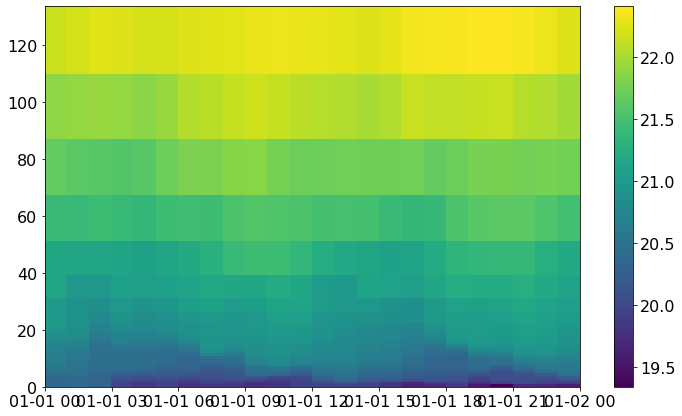

In [39]:
fig, ax=plt.subplots(1,1,figsize=(12,7))
m0=ax.pcolormesh(nitrate.columns,nitrate.index,nitrate,shading='auto')
fig.colorbar(m0)

Hmm. It is clear to me that the automatic stuff here does not work so good for the ranges considering the fact that all of the nitrate values go to 0 after a certain depth. Why do they suddenly become zero anyway?

In [17]:
bio.close()